In [23]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import hmf
import glob
import corner
import emcee
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
from scipy import integrate

In [24]:
cosmo = FlatLambdaCDM( 70 , 0.3 )

List of catalogs

In [25]:
beta = 370 * 1e3 / 3e8
beta

0.0012333333333333332

In [26]:
kappa = ( 6 * 1e-8  / ( 4 * 3.141 ) ) **0.5
kappa

6.910534847721006e-05

In [27]:
kappa / beta

0.05603136363017032

Load one of the catalogs

In [28]:
catalog = pd.read_csv('converted_plc_mock0001.dat',sep=' ',skiprows=12, names=['M','z','ra','dec'])

In [29]:
catalog[:5]

,M,z,ra,dec
0,1.009264e+14,0.086050,32.595188,180.504166
1,1.512869e+14,0.087630,41.722706,191.793549
2,1.669313e+14,0.043425,48.389835,171.732162
3,1.164017e+14,0.070921,73.648537,191.975937
4,3.254934e+14,0.056347,46.342659,31.519432


In [30]:
np.max( catalog['z'] )

1.9999058246612549

In [117]:
len( catalog )

130100

Plot the hmf in a bin of redshift vs despali

In [10]:
sub_cat = catalog[ ( catalog['z'] > 0.4 ) & ( catalog['z'] < 0.5 ) ]

In [118]:
np.min( catalog['z'] ) , np.max( catalog['z'] )

(0.0158388689160347, 1.9999058246612549)

In [11]:
np.min( np.log10( sub_cat['M'] ) ), np.max( np.log10( sub_cat['M'] ) )

(14.000018370067735, 15.235222149910093)

In [34]:
len( sub_cat )

13482

In [201]:
dm = 0.2
m_bins = np.arange( 14 , 15.3 , dm )
m_cent = ( m_bins[1:] + m_bins[:-1] )/2.

In [202]:
counts , _ = np.histogram( np.log10( sub_cat['M'] ) , bins = m_bins )

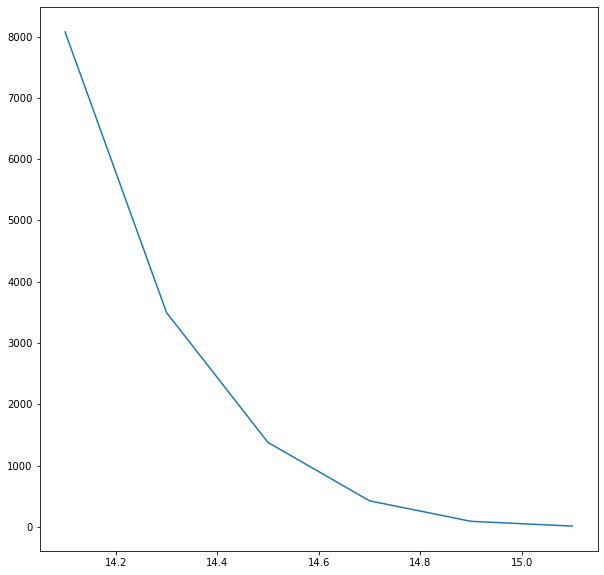

In [203]:
plt.figure( figsize = ( 10 , 10 ) )
plt.plot( m_cent , counts )

In [204]:
n = np.cumsum( counts )

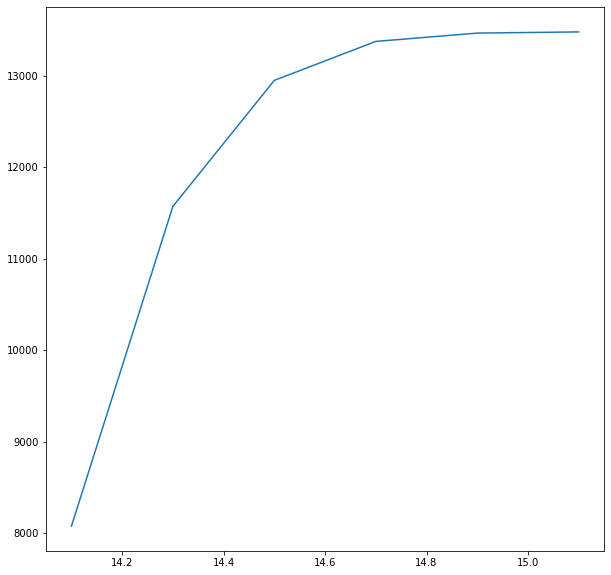

In [205]:
plt.figure( figsize = ( 10 , 10 ) )
plt.plot( m_cent , n )

In [206]:
def th_counts( params ):
    '''Compute the number of halos in a given area'''

    k = 10  # Precision for integration
    H0, Om0 , sigma_8 , z_min, z_max, dz, M_min, M_max, dlogm, square_degree = params
    dz0 = dz/k
    cosmo_model = FlatLambdaCDM(H0=H0, Om0=Om0 , Ob0 = 0.05 , Tcmb0 = 2.7)
    h0 = H0/100
    h = hmf.MassFunction( cosmo_model= cosmo_model , 
                          dlog10m=dlogm/k, 
                          Mmin=np.log10(h0)+M_min, 
                          Mmax=np.log10(h0)+M_max+(k+2)*(dlogm/k), 
                          sigma_8=sigma_8, 
                          z=z_min, 
                          #delta_h=200, 
                          #delta_wrt='crit')
                        )
    N = len(h.m)
    z = np.arange(z_min, z_max+(k+2)*dz0, dz0)
    z_bins = len(z)

    d2Ndzdlnm = np.zeros((N, z_bins))
    for j in range(0, z_bins):

        h.update(z=z_min+j*dz0)
        n_test = h.dndlnm  # !!!! quel log
        A = ( h0 ** 3 ) * square_degree * ( np.pi / 180 )**2
        dVdz = cosmo_model.differential_comoving_volume( z_min + j * dz0 ).value * A
        n_test = n_test*dVdz
        d2Ndzdlnm[:, j] = n_test

    m0 = np.arange(M_min, M_max, dlogm)
    z0 = np.arange(z_min, z_max, dz)
    N0 = len(np.arange(M_min, M_max, dlogm))
    z0_bins = len(np.arange(z_min, z_max, dz))
    results = np.zeros((N0, z0_bins))
    for j in range(0, z0_bins):
        for i in range(0, N0):
            A = d2Ndzdlnm[i*k:(i+1)*k+1, j*k:(j+1)*k+1]
            results[i, j] = integrate.simps(integrate.simps(
                A, dx=(dlogm/k)/np.log10(np.exp(1)), axis=0), dx=dz0)
    return results, m0, z0

In [ ]:
hmf_despali.dnx

In [207]:
n_arr , m_arr , z_arr = th_counts( [ 70 , 0.3 , 1 , 0 , 2 , 0.1 , 14 , 15.5 , 0.1 , 41253/4 ])

In [208]:
z_arr[5]

0.5

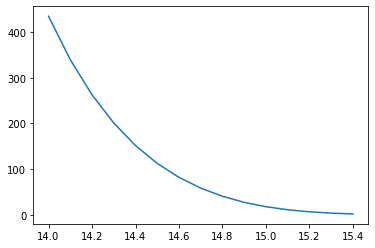

In [209]:
plt.plot( m_arr , n_arr.T[0] )

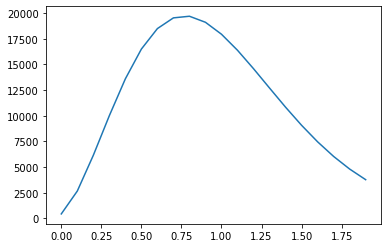

In [210]:
plt.plot( z_arr , n_arr[0] )

Text(0, 0.5, 'N')

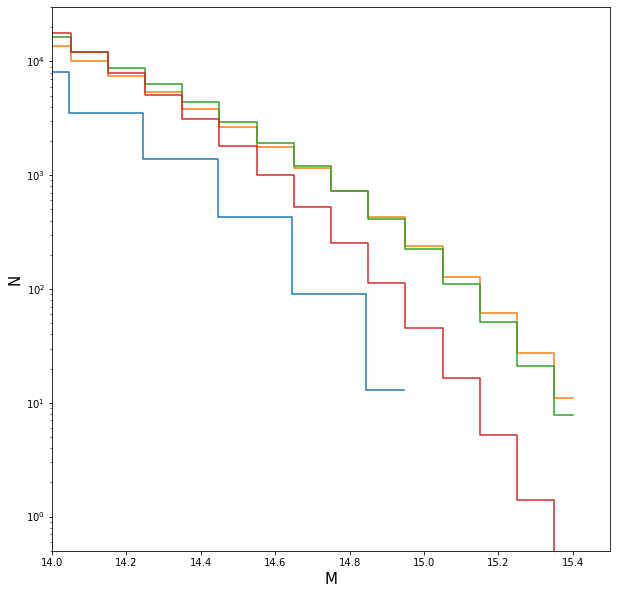

In [211]:
plt.figure( figsize = ( 10 , 10 ) )
plt.plot( np.log10( 10**m_cent * 0.7 ) , counts , drawstyle='steps-mid' )
plt.plot( m_arr , n_arr.T[4] , drawstyle='steps-mid' ) 
plt.plot( m_arr , n_arr.T[5] , drawstyle='steps-mid' ) 
plt.plot( m_arr , n_arr.T[10] , drawstyle='steps-mid' ) 
plt.yscale('log')
plt.xlim( 14 , 15.5 )
plt.ylim( 0.5 , 3e4 )
plt.xlabel( 'M' , fontsize = 15 )
plt.ylabel( 'N' , fontsize = 15 )

Cluster likelihood

In [ ]:
# unbinned poisson log likelihood
def upoisson_ln_l()L

# binned poisson log likelihood
def bpoisson_ln_l():